In [5]:
%%timeit x = range(10000)
    max(x)

1000 loops, best of 3: 229 µs per loop


In [8]:
import pandas as pd
import numpy as np
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from pprint import pprint
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.svm import LinearSVC, NuSVC, SVC

## Parte 3 Análisis de emociones en tweets

#### (a) Construya un dataframe con los datos a analizar. Determine cu´antas clases existen, cu´antos registros por clase y describa el *dataset*.

In [9]:
df = pd.read_csv("text_emotion.csv")

In [10]:
#pd.crosstab(df['author'],df['sentiment'],margins=True)

In [11]:
errores = {}

In [12]:
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [13]:
df.drop(['tweet_id'],axis=1,inplace=True)

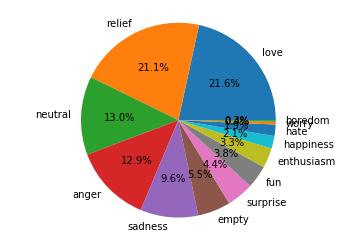

In [14]:
sentiment_counts = df['sentiment'].value_counts()
#print sentiment_counts
#print list(set(df.sentiment.values))
plt.pie(sentiment_counts,labels=list(set(df.sentiment.values)),autopct='%1.1f%%')
plt.axis('equal')
plt.show()

#### (b) Construya un conjunto de entrenamiento y otro de pruebas, a trav´es de una m´ascara aleatoria, para verificar los resultados de los algoritmos.

In [15]:

msk = np.random.rand(len(df)) < 0.8
train = pd.DataFrame(df[msk])
test = pd.DataFrame(df[~msk])

(c)	Implemente y explique un pre-procesamiento para los tweets para dejarlos en un formato est´andarizado en el cual se podr´an trabajar.

In [16]:
#preproccesing functions
def coding(col,codeDict):
    colCoded = pd.Series(col,copy=True)
    for key,value in codeDict.items():
        colCoded.replace(key,value,inplace=True)
    return colCoded
def num_missing(x):
    return sum(x.isnull())

In [17]:
# Se nota que no faltan datos en el df
print train.apply(num_missing,axis=0)

sentiment    0
author       0
content      0
dtype: int64


In [18]:
#estandarizacion del texto en la columna content mediante liberias de re y nlt
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

#Cambia el texto de cualquier forma presente a minusculas
def normalizer(content):
    without_user_name = re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)"," ",content)
    without_links = re.sub("https?:\/\/.*[\r\n]*"," ",without_user_name)
    short_words = re.sub("\b\w\b"," ",without_links)
    #without_hashtags = re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9]+)"," ",without_links)
    only_letters = re.sub("[^a-zA-Z]", " ",short_words) 
    tokens = nltk.word_tokenize(only_letters)
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t,pos='v') for t in filtered_result]
    return lemmas


In [19]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
train['normalized_tweet'] = train.content.apply(normalizer)
test['normalized_tweet'] = test.content.apply(normalizer)

In [20]:
train[['content','normalized_tweet']].head(100)

,content,normalized_tweet
1,Layin n bed with a headache ughhhh...waitin on your call...,"[layin, n, bed, headache, ughhhh, waitin, call]"
4,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","[want, trade, someone, houston, ticket, one]"
5,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,"[ping, go, prom, bc, bf, like, friends]"
6,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!","[sleep, im, think, old, friend, want, marry, damn, amp, want, scandalous]"
7,Hmmm. http://www.djhero.com/ is down,[hmmm]
8,@charviray Charlene my love. I miss you,"[charlene, love, miss]"
9,@kelcouch I'm sorry at least it's Friday?,"[sorry, least, friday]"
10,cant fall asleep,"[cant, fall, asleep]"
11,Choked on her retainers,"[choke, retainers]"
13,@BrodyJenner if u watch the hills in london u will realise what tourture it is because were weeks and weeks late i just watch itonlinelol,"[u, watch, hill, london, u, realise, tourture, weeks, weeks, late, watch, itonlinelol]"


#### (d)	Haga una reducci´on binaria al problema, para trabajarlo como un problema de clasificaci´on de dos clases. Para esto, agrupe las distintas emociones como positivas y negativas (defina un criterio), se recomienda codificar las clases como +1 y −1 respectivamente. Recuerde tener presente que el desbalanceo de los datos puede afectar considerablemente al modelo.

In [21]:
dictionary = {"anger": -1,"boredom": -1,"empty": -1,"enthusiasm": 1,"fun": 1,"happiness": 1,"hate": -1,"love": 1,"neutral": 1,"relief": 1,"sadness": -1,"surprise" : -1,"worry": -1}
train['sentiment'] = coding(train['sentiment'],dictionary)
dictionary = {"anger": -1,"boredom": -1,"empty": -1,"enthusiasm": 1,"fun": 1,"happiness": 1,"hate": -1,"love": 1,"neutral": 1,"relief": 1,"sadness": -1,"surprise" : -1,"worry": -1}
test['sentiment'] = coding(test['sentiment'],dictionary)


 1    17345
-1    14608
Name: sentiment, dtype: int64


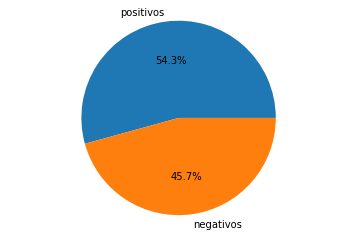

In [22]:
sentiment_counts = train['sentiment'].value_counts()
print sentiment_counts
plt.pie(sentiment_counts,labels=['positivos','negativos'],autopct='%1.1f%%')
plt.axis('equal')
plt.show()

#### (e)	Para construir un clasificador que determine autom´aticamente la polaridad de un trozo de texto, ser´a necesario representar los tweets $\{t_{i}\}^{n}_{i=1}$ disponibles como vectores de caracter´ısticas (features). El tipo de caracter´ısticas m´as utilizado consiste en contar cu´antas veces aparecen ciertos t´erminos/palabras en el texto. Para esto, es necesario un vocabulario que, por lo general, se construye mediante la uni´on de todas las palabras que se observen en los tweets.

In [23]:
traindata = [" ".join(x) for x in train.normalized_tweet]
testdata = [" ".join(x) for x in test.normalized_tweet]

train_label = train.sentiment
test_label = test.sentiment

In [24]:
count_vec = CountVectorizer(lowercase = False)
count_vec.fit(traindata)

Xtrain = count_vec.transform(traindata)
Xtest = count_vec.transform(testdata)

print Xtrain.shape
print Xtest.shape

(31953, 22524)
(8047, 22524)


In [25]:
tf_transformer = TfidfTransformer(use_idf=False).fit(Xtrain)
Xtrain_tf = tf_transformer.transform(Xtrain)
print Xtrain_tf.shape
Xtest_tf = tf_transformer.transform(Xtest)
print Xtest_tf.shape

(31953, 22524)
(8047, 22524)


#### (f)	Entrene y compare al menos 5 de los diferentes clasificadores vistos en clases para clasificaci´on binaria (por ejemplo: Navie Bayes, Multinomial Naive Bayes, LDA, QDA, Regresi´on log´ıstica, SVM y Arboles de decisi´on) sobre el conjunto de entrenamiento verificando su desempen˜o sobre ambos conjuntos (entrenamiento y de pruebas), construyendo un gr´afico resumen del error de ´estos

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [27]:
bnb= BernoulliNB()
#fitting
bnb.fit(Xtrain_tf, train_label)
#ypred
ypredBnb = bnb.predict(Xtest_tf)
print ypredBnb.shape
print test_label.shape
print ('Bernoulli accuracy score')
print (accuracy_score(test_label, ypredBnb))
errores['Bernoulli']=[accuracy_score(test_label, ypredBnb)]


(8047,)
(8047,)
Bernoulli accuracy score
0.684975767367


Confusion matrix, without normalization
[[2108 1534]
 [1001 3404]]


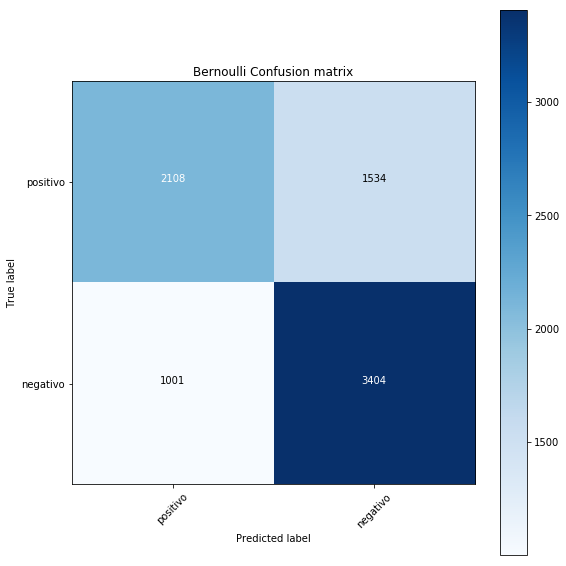

In [28]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label, ypredBnb), classes=['positivo','negativo'],
                      title='Bernoulli Confusion matrix')

plt.show()

In [29]:
mnb= MultinomialNB()
#fitting
mnb.fit(Xtrain_tf, train_label)
#ypred
ypredmnb = mnb.predict(Xtest_tf)
print ('Multinomial accuracy score')
print (accuracy_score(test_label, ypredmnb))
errores['Multinomial']=[accuracy_score(test_label, ypredmnb)]


Multinomial accuracy score
0.68360879831


Confusion matrix, without normalization
[[2003 1639]
 [ 907 3498]]


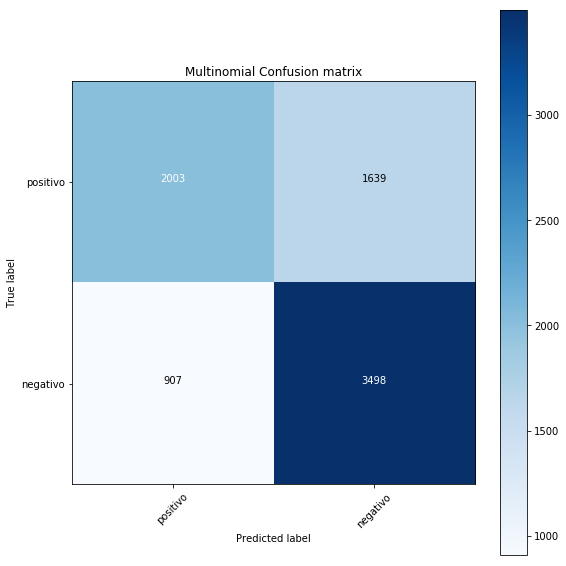

In [30]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label, ypredmnb), classes=['positivo','negativo'],
                      title='Multinomial Confusion matrix')

plt.show()

In [31]:
from sklearn.linear_model import LogisticRegression
C_array = [0.01,0.1,0.7,0.8,1,10,100,1000]
best = 0.0
c_b = 0.01
for C in C_array:
    lr = LogisticRegression(penalty='l2',C=C)
    lr.fit(Xtrain_tf, train_label)
    ypredlr = lr.predict(Xtest_tf)
    print ('Logistic Regression accuracy score C= %f'%C)
    acc = accuracy_score(test_label, ypredlr)
    print (acc)
    if(acc > best):
        best = acc
        ypredlr_b = ypredlr
    

Logistic Regression accuracy score C= 0.010000
0.629178575867
Logistic Regression accuracy score C= 0.100000
0.680626320368
Logistic Regression accuracy score C= 0.700000
0.69529017025
Logistic Regression accuracy score C= 0.800000
0.696035789735
Logistic Regression accuracy score C= 1.000000
0.696781409221
Logistic Regression accuracy score C= 10.000000
0.681247669939
Logistic Regression accuracy score C= 100.000000
0.654902448117
Logistic Regression accuracy score C= 1000.000000
0.631166894495


In [32]:
errores['LR']=[accuracy_score(test_label, ypredlr_b)]

Confusion matrix, without normalization
[[2223 1419]
 [1021 3384]]


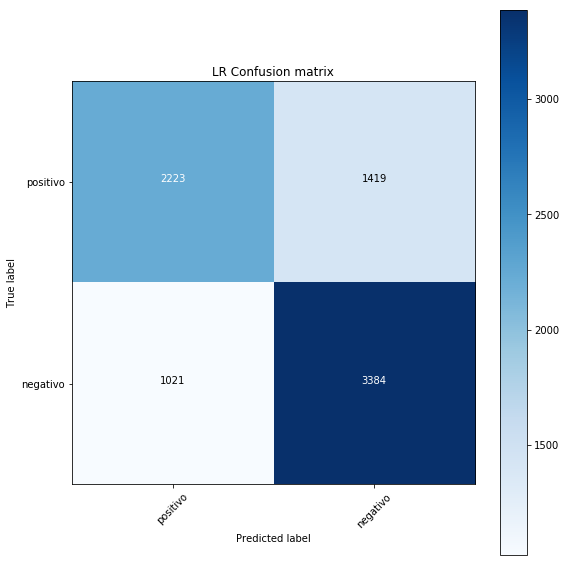

In [33]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label, ypredlr_b), classes=['positivo','negativo'],
                      title='LR Confusion matrix')

plt.show()

In [34]:
lsvm= LinearSVC()
#fitting
lsvm.fit(Xtrain_tf, train_label)
#ypred
ypredlsvm = lsvm.predict(Xtest_tf)
print ('Linear Svm accuracy score')
print (accuracy_score(test_label, ypredlsvm))
errores['LinearSVM']=[accuracy_score(test_label, ypredlsvm)]

Linear Svm accuracy score
0.680129240711


In [ ]:
nusvm=NuSVC(kernel='linear',cache=300)
#fitting
nusvm.fit(Xtrain_tf, train_label)
#ypred
ypredNusvm = nusvm.predict(Xtest_tf)
print ('Non Linear svm accuracy score')
print (accuracy_score(test_label, ypredNusvm))
errores['NonLinearSVM']=[accuracy_score(test_label, ypredNusvm)]

In [142]:
nusvmpoly=NuSVC(kernel='poly',cache=300)
#fitting
nusvmpoly.fit(Xtrain_tf, train_label)
#ypred
ypredNusvmpoly = nusvmpoly.predict(Xtest_tf)
print ('Non Linear poly svm accuracy score')
print (accuracy_score(test_label, ypredNusvmpoly))
errores['NonLinearPoly']=[accuracy_score(test_label, ypredNusvmpoly)]

Non Linear poly svm accuracy score
0.640724547158


In [164]:
nusvmrbf=NuSVC(kernel='rbf')
#fitting
nusvmrbf.fit(Xtrain_tf, train_label)
#ypred
ypredNusvmrbf = nusvmpoly.predict(Xtest_tf)
print ('Non Linear rbf svm accuracy score')
print (accuracy_score(test_label, ypredNusvmrbf))
errores['NonLinearRbf']=[accuracy_score(test_label, ypredNusvmrbf)]

Non Linear rbf svm accuracy score
0.640724547158


In [168]:
C_array = [1000,5000,10000,20000]
best = 0.0
c_b = 0.01
for C in C_array:
    svcrbf = SVC(C=C,kernel='poly')
    svcrbf.fit(Xtrain_tf, train_label)
    ypredsvcp = model.predict(Xtest_tf)
    print ('SVC accuracy score C= %f'%C)
    acc = accuracy_score(test_label, ypredsvcp)
    print (acc)
    if(acc > best):
        best = acc
        ypredsvcp_b = ypredsvcp
    

SVC accuracy score C= 1000.000000
0.707058088695
SVC accuracy score C= 5000.000000
0.707058088695
SVC accuracy score C= 10000.000000
0.707058088695
SVC accuracy score C= 20000.000000
0.707058088695


In [ ]:
errores['CSVM']=[accuracy_score(test_label, ypredsvcp_b)]

(g)	Utilice y explique las m´etricas que calcula la funci´on classification report de la librer´ıa sklearn. En base a las distintas m´etricas calculadas ¿Cu´ales clasificadores son los que mejor se comportan?

In [206]:
from sklearn.metrics import classification_report
def score_the_model(model,x,y,xt,yt,name,targets):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print "%s Training Accuracy: %f"%(name,acc_tr)
    print "%s Test Accuracy: %f"%(name,acc_test)
    print "Detailed Analysis Testing Results ..."
    print (classification_report(yt, model.predict(xt),target_names=targets))


La función classification_report()calcula 4 métricas (precision, recall, f1-score, support).Donde el significado de precision es una indice entre los true positive y false positive, es decir representa la habilidad para clasificar correctamente las clases, algo parecido como se ve arriba con la matriz de confusión. El significado de recall tasa entre los true positive y el resto de las clases que no son el target ( true positive + false negative), esto representa la habilidad del clasificador en no dejar fuera los ejemplos de la clase propia, es decir, etiquetar correctamente los de la clase objetivo . f1-score realiza un promedio harmónico/ponderado entre las métricas de precision y recall , su dominio va de 0 a 1 con su mejor en 1. Finalmente support es el indice de la cantidad de ejemplos usados en la clase

In [155]:
score_the_model(bnb,Xtrain_tf,train_label,Xtest_tf,test_label,"Bernoulli Naive Bayes",["positivo","negativo"])

Bernoulli Naive Bayes Training Accuracy: 0.804469
Bernoulli Naive Bayes Test Accuracy: 0.702649
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.69      0.61      0.65      3616
   negativo       0.71      0.78      0.74      4389

avg / total       0.70      0.70      0.70      8005



In [156]:
score_the_model(mnb,Xtrain_tf,train_label,Xtest_tf,test_label,"Multinomial Naive Bayes",["positivo","negativo"])

Multinomial Naive Bayes Training Accuracy: 0.779778
Multinomial Naive Bayes Test Accuracy: 0.697401
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.70      0.57      0.63      3616
   negativo       0.69      0.80      0.74      4389

avg / total       0.70      0.70      0.69      8005



In [160]:
score_the_model(lr,Xtrain_tf,train_label,Xtest_tf,test_label,"Logistic Regresion",["positivo","negativo"])

Linear SVM Training Accuracy: 0.900078
Linear SVM Test Accuracy: 0.639180
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.61      0.58      0.59      3616
   negativo       0.66      0.69      0.68      4389

avg / total       0.64      0.64      0.64      8005



In [161]:
score_the_model(lsvm,Xtrain_tf,train_label,Xtest_tf,test_label,"Linear SVM",["positivo","negativo"])

Logistic Regresion Training Accuracy: 0.843007
Logistic Regresion Test Accuracy: 0.692279
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.67      0.62      0.65      3616
   negativo       0.71      0.75      0.73      4389

avg / total       0.69      0.69      0.69      8005



In [162]:
score_the_model(nusvm,Xtrain_tf,train_label,Xtest_tf,test_label,"No linear SVM kernel lineal",["positivo","negativo"])

No linear SVM kernel lineal Training Accuracy: 0.864916
No linear SVM kernel lineal Test Accuracy: 0.679410
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.66      0.61      0.63      3616
   negativo       0.70      0.74      0.72      4389

avg / total       0.68      0.68      0.68      8005



In [163]:
score_the_model(nusvmpoly,Xtrain_tf,train_label,Xtest_tf,test_label,"No linear SVM kernel poly",["positivo","negativo"])

No linear SVM kernel poly Training Accuracy: 0.767245
No linear SVM kernel poly Test Accuracy: 0.640680
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.58      0.71      0.64      3616
   negativo       0.71      0.59      0.64      4389

avg / total       0.65      0.64      0.64      8005



In [165]:
score_the_model(nusvmrbf,Xtrain_tf,train_label,Xtest_tf,test_label,"No linear SVM kernel rbf",["positivo","negativo"])

No linear SVM kernel rbf Training Accuracy: 0.698453
No linear SVM kernel rbf Test Accuracy: 0.687031
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.74      0.47      0.58      3616
   negativo       0.66      0.87      0.75      4389

avg / total       0.70      0.69      0.67      8005



[Opcional] Visualice las predicciones de algu´n modelo generativo (probabil´ıstico) definido anteriormente, tomando un subconjunto aleatorio de tweets de pruebas y explorando las probabilidades que asigna el clasificador a cada clase.

In [191]:
import random
test_pred = lr.predict_proba(Xtest_tf)
spl = random.sample(xrange(len(test_pred)), 5)
for text, sentiment in zip(df.content[spl], test_pred[spl]):
    if(sentiment[0]>sentiment[1]):
        print '[+]'+text
    else:
        print '[-]'+text

[+]There is something wrong with me! I'm so tired I can barely keep my eyes open. Yet all I've done for the last 3hrs is toss &amp; turn in bed
[+]It has come to my attention from a 16yo friend that I've recently gained a TON of weight. He didn't know it was me.
[+]The Good: I drank Jager and licked a hot asian girl's foot. The Bad: I was reminded once again that I will never get asian girls ever.
[+]Sitting by myself. Everyone took the good seats.
[-]Nooo i wanna watch the comet  dont wanna go workk!!!


(i)	Ahora deber´a extender el problema a las mu´ltiples clases que tiene presente (las distintas emociones), es decir, su trabajo ser´a el de predecir una de las distintas emociones de cada tweet. Para esto utilice el mismo pre-procesamiento realizado en el punto c) y las caracter´ısticas generadas mediante las t´ecnicas en el punto e). Recuerde que tendr´a que codificar las distintas clases como valores num´ericos enteros.

In [192]:
msk = np.random.rand(len(df)) < 0.8
train2 = pd.DataFrame(df[msk])
test2 = pd.DataFrame(df[~msk])

In [194]:
train2['normalized_tweet'] = train2.content.apply(normalizer)
test2['normalized_tweet'] = test2.content.apply(normalizer)

In [3]:
df_err = pd.DataFrama()

NameError: name 'pd' is not defined

In [195]:
dictionary = {"anger": 0,"boredom": 1,"empty": 2,"enthusiasm": 3,"fun": 4,"happiness": 5,"hate": 6,"love": 7,"neutral": 8,"relief": 9,"sadness": 10,"surprise" : 11,"worry": 12}
train2['sentiment'] = coding(train2['sentiment'],dictionary)
dictionary = {"anger": 0,"boredom": 1,"empty": 2,"enthusiasm": 3,"fun": 4,"happiness": 5,"hate": 6,"love": 7,"neutral": 8,"relief": 9,"sadness": 10,"surprise" : 11,"worry": 12}
test2['sentiment'] = coding(test2['sentiment'],dictionary)


In [197]:
traindata2 = [" ".join(x) for x in train2.normalized_tweet]
testdata2 = [" ".join(x) for x in test2.normalized_tweet]

train_label2 = train2.sentiment
test_label2 = test2.sentiment


In [198]:
count_vec2 = CountVectorizer(lowercase = False)
count_vec2.fit(traindata)

Xtrain2 = count_vec2.transform(traindata2)
Xtest2 = count_vec2.transform(testdata2)

In [199]:
tf_transformer2 = TfidfTransformer(use_idf=False).fit(Xtrain2)
Xtrain_tf2 = tf_transformer2.transform(Xtrain2)

Xtest_tf2 = tf_transformer2.transform(Xtest2)


(j)	Utilice los clasificadores que son extendidos por defecto a mu´ltiples clases para detectar emociones en cada tweet, muestre sus desempen˜os a trav´es del error de pruebas en un gr´afico resumen.

Bernoulli accuracy score
0.320402834763
Confusion matrix, without normalization
[[   0    0    0    0    0    0    0    1   12    0    3    0    8]
 [   0    0    0    0    0    0    0    0   13    0    1    0   21]
 [   0    0    0    0    0    7    0    0   94    0    5    0   58]
 [   0    0    0    0    0    3    0    3   81    0    8    0   48]
 [   0    0    0    0    0   59    0    9  195    0    5    0   98]
 [   0    0    0    0    0  162    0   62  559    0   15    0  262]
 [   0    0    0    0    0    6    0    0  102    0   19    0  189]
 [   0    0    0    0    0   90    0  140  344    0    7    0  171]
 [   0    0    0    0    1   58    0   30 1275    0   26    1  426]
 [   0    0    0    0    0   25    0    8  150    0    4    0   99]
 [   0    0    0    0    0   27    0    6  327    0   69    0  569]
 [   0    0    0    0    0   21    0   11  210    0   10    1  158]
 [   0    0    0    0    0   49    0   12  623    0   56    1  930]]


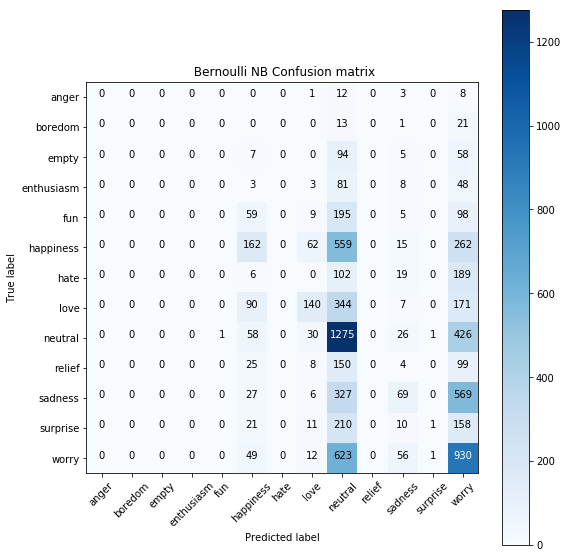

Multinomial Naive Bayes Training Accuracy: 0.447946
Multinomial Naive Bayes Test Accuracy: 0.320443
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

      anger       0.00      0.00      0.00        24
    boredom       0.00      0.00      0.00        35
      empty       0.00      0.00      0.00       164
 enthusiasm       0.00      0.00      0.00       143
        fun       0.00      0.00      0.00       366
  happiness       0.32      0.15      0.21      1060
       hate       0.00      0.00      0.00       316
       love       0.50      0.19      0.27       752
    neutral       0.32      0.70      0.44      1817
     relief       0.00      0.00      0.00       286
    sadness       0.30      0.07      0.11       998
   surprise       0.33      0.00      0.00       411
      worry       0.31      0.56      0.40      1671

avg / total       0.28      0.32      0.25      8043



In [208]:
bnb2= BernoulliNB()
#fitting
bnb2.fit(Xtrain_tf2, train_label2)
#ypred
ypredBnb2 = bnb2.predict(Xtest_tf2)

print ('Bernoulli accuracy score')
print (accuracy_score(test_label2, ypredBnb2))

plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label2, ypredBnb2), 
                      classes=["anger","boredom","empty","enthusiasm",
                               "fun","happiness","hate","love","neutral",
                               "relief","sadness","surprise","worry"],
                      title=' Bernoulli NB Confusion matrix')

plt.show()

score_the_model(bnb2,Xtrain_tf2,train_label2,Xtest_tf2,test_label2,"Multinomial Naive Bayes",
                ["anger","boredom","empty","enthusiasm",
                               "fun","happiness","hate","love","neutral",
                               "relief","sadness","surprise","worry"])


Bernoulli accuracy score
0.309088648514
Confusion matrix, without normalization
[[   0    0    0    0    0    0    0    1   12    0    3    0    8]
 [   0    0    0    0    0    0    0    0   13    0    1    0   21]
 [   0    0    0    0    0    7    0    0   94    0    5    0   58]
 [   0    0    0    0    0    3    0    3   81    0    8    0   48]
 [   0    0    0    0    0   59    0    9  195    0    5    0   98]
 [   0    0    0    0    0  162    0   62  559    0   15    0  262]
 [   0    0    0    0    0    6    0    0  102    0   19    0  189]
 [   0    0    0    0    0   90    0  140  344    0    7    0  171]
 [   0    0    0    0    1   58    0   30 1275    0   26    1  426]
 [   0    0    0    0    0   25    0    8  150    0    4    0   99]
 [   0    0    0    0    0   27    0    6  327    0   69    0  569]
 [   0    0    0    0    0   21    0   11  210    0   10    1  158]
 [   0    0    0    0    0   49    0   12  623    0   56    1  930]]


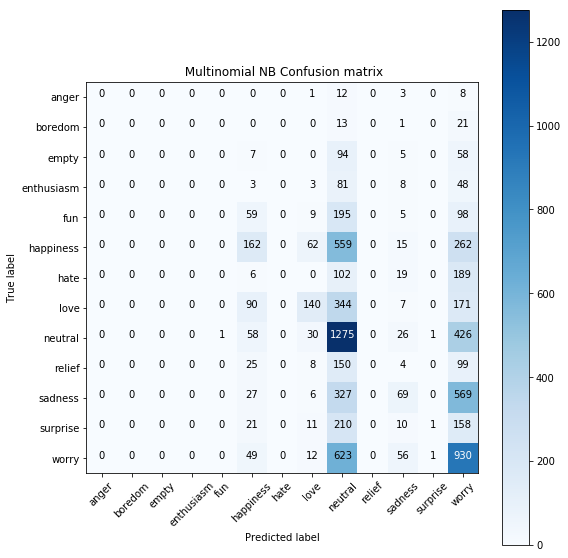

Multinomial Naive Bayes Training Accuracy: 0.395125
Multinomial Naive Bayes Test Accuracy: 0.309127
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

      anger       0.00      0.00      0.00        24
    boredom       0.00      0.00      0.00        35
      empty       0.00      0.00      0.00       164
 enthusiasm       0.00      0.00      0.00       143
        fun       0.00      0.00      0.00       366
  happiness       0.37      0.16      0.22      1060
       hate       0.00      0.00      0.00       316
       love       0.55      0.19      0.28       752
    neutral       0.33      0.50      0.40      1817
     relief       0.00      0.00      0.00       286
    sadness       0.46      0.03      0.05       998
   surprise       0.00      0.00      0.00       411
      worry       0.27      0.74      0.40      1671

avg / total       0.29      0.31      0.24      8043



In [207]:
mnb2= MultinomialNB()
#fitting
mnb2.fit(Xtrain_tf2, train_label2)
#ypred
ypredMnb2 = mnb2.predict(Xtest_tf2)

print ('Bernoulli accuracy score')
print (accuracy_score(test_label2, ypredMnb2))

plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label2, ypredBnb2), 
                      classes=["anger","boredom","empty","enthusiasm",
                               "fun","happiness","hate","love","neutral",
                               "relief","sadness","surprise","worry"],
                      title=' Multinomial NB Confusion matrix')

plt.show()
score_the_model(mnb2,Xtrain_tf2,train_label2,Xtest_tf2,test_label2,"Multinomial Naive Bayes",
                ["anger","boredom","empty","enthusiasm",
                               "fun","happiness","hate","love","neutral",
                               "relief","sadness","surprise","worry"])

In [214]:
from sklearn.linear_model import LogisticRegression
C_array2 = [0.01,0.4,0.5,0.6,0.7,0.8,1,10]
best2 = 0.0
c_b2 = 0.01
for C in C_array2:
    lr2 = LogisticRegression(penalty='l2',C=C)
    lr2.fit(Xtrain_tf2, train_label2)
    ypredlr2 = lr2.predict(Xtest_tf2)
    print ('Logistic Regression accuracy score C= %f'%C)
    acc2 = accuracy_score(test_label2, ypredlr2)
    print (acc2)
    if(acc2 > best2):
        best2 = acc2
        ypredlr_b2 = ypredlr2

Logistic Regression accuracy score C= 0.010000
0.296655476812
Logistic Regression accuracy score C= 0.400000
0.351610095735
Logistic Regression accuracy score C= 0.500000
0.354221061793
Logistic Regression accuracy score C= 0.600000
0.357702349869
Logistic Regression accuracy score C= 0.700000
0.359194330474
Logistic Regression accuracy score C= 0.800000
0.358199676738
Logistic Regression accuracy score C= 1.000000
0.356459032699
Logistic Regression accuracy score C= 10.000000
0.336192962825


Confusion matrix, without normalization
[[   0    0    0    0    0    1    0    1   12    0    2    0    8]
 [   0    0    0    0    0    2    0    0   10    0    6    0   17]
 [   0    0    0    0    0   12    0    2   96    1    8    1   44]
 [   0    0    0    0    0   20    0    7   60    0   10    1   45]
 [   0    0    0    0    2  100    0   24  139    1   16    3   81]
 [   0    0    0    0    6  373    4  105  369    1   18    7  177]
 [   0    0    0    0    0    4   35    6  100    0   34    1  136]
 [   0    0    0    0    2  152    1  300  187    0   20    3   87]
 [   0    0    0    0    2  180    5   60 1125    2   70    5  368]
 [   0    0    0    0    1   59    0   14  115    9    8    0   80]
 [   0    0    0    0    0   50   11   30  255    1  215    4  432]
 [   0    0    0    0    1   48    2   23  170    1   19   17  130]
 [   0    0    0    0    2  102   14   39  532    1  162    6  813]]


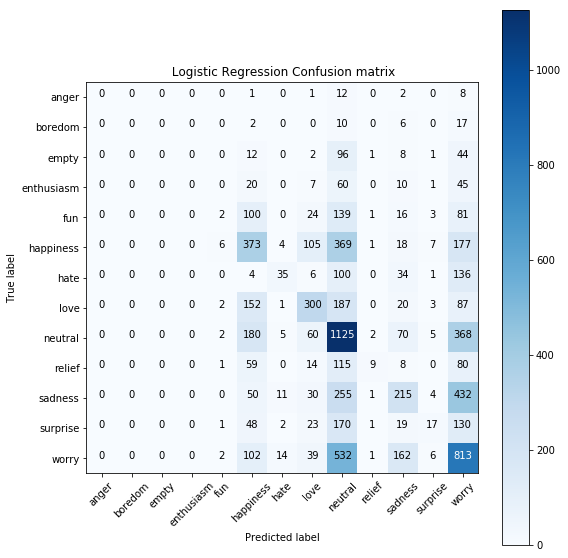

In [215]:
lr2 = LogisticRegression(penalty='l2',C=0.7)
lr2.fit(Xtrain_tf2, train_label2)
ypredlr2 = lr2.predict(Xtest_tf2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label2, ypredlr2), 
                      classes=["anger","boredom","empty","enthusiasm",
                               "fun","happiness","hate","love","neutral",
                               "relief","sadness","surprise","worry"],
                      title=' Logistic Regression Confusion matrix')

plt.show()

(k)	Utilice clasificadores binarios que pueden ser extendidos a trav´es de otras t´ecnicas, tal como One vs One y One vs All/Rest [14]

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
clf1 = OneVsRestClassifier(SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output1 = clf1.fit(Xtrain_tf2, train_label2)

(l) Para el caso de la Regresi´on Log´ıstica compare sus dos m´etodos para ser extendidos a mu´ltiples clases. Uno a trav´es de One vs Rest y otro definiendo que la variable a predecir se distribuye Multinomial.

Confusion matrix, without normalization
[[   0    0    0    0    0    1    0    1   12    0    2    0    8]
 [   0    0    0    0    0    2    0    0   10    0    6    0   17]
 [   0    0    0    0    0   11    1    2   95    3    8    1   43]
 [   0    0    0    0    0   21    0    5   61    0   11    1   44]
 [   0    0    0    0    4  100    0   26  143    1   16    3   73]
 [   0    0    0    0   10  376    4  106  356    2   18    8  180]
 [   0    0    0    0    0    4   37    6   98    0   40    1  130]
 [   0    0    0    0    2  155    2  304  179    1   19    4   86]
 [   0    0    0    0    4  190    6   63 1085    3   80    7  379]
 [   0    0    0    0    1   60    0   14  115   11    9    1   75]
 [   0    0    0    0    1   48   17   29  253    1  229    5  415]
 [   0    0    0    0    1   51    2   24  162    1   25   19  126]
 [   0    0    0    0    2  105   15   40  518    1  180    8  802]]


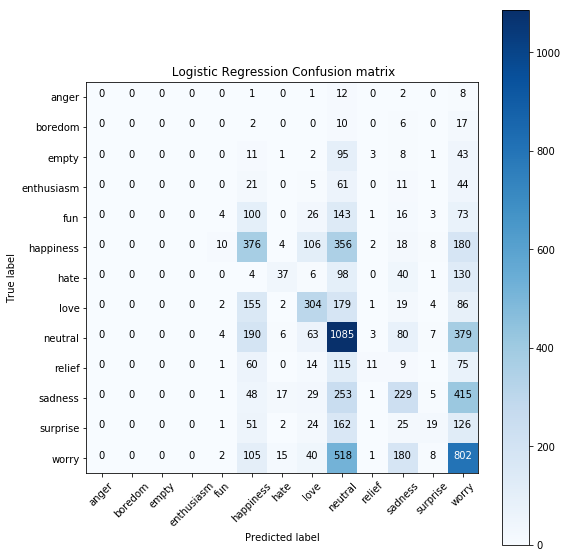

In [221]:
lr3 = LogisticRegression(multi_class='ovr').fit(Xtrain_tf2, train_label2)
ypredlr3 = lr3.predict(Xtest_tf2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label2, ypredlr3), 
                      classes=["anger","boredom","empty","enthusiasm",
                               "fun","happiness","hate","love","neutral",
                               "relief","sadness","surprise","worry"],
                      title=' Logistic Regression Confusion matrix')

plt.show()

Confusion matrix, without normalization
[[   0    0    0    0    0    1    0    1   12    0    2    0    8]
 [   0    0    0    0    0    2    0    0   10    0    6    0   17]
 [   0    0    0    0    0   11    1    2   95    3    8    1   43]
 [   0    0    0    0    0   21    0    5   61    0   11    1   44]
 [   0    0    0    0    4  100    0   26  143    1   16    3   73]
 [   0    0    0    0   10  376    4  106  356    2   18    8  180]
 [   0    0    0    0    0    4   37    6   98    0   40    1  130]
 [   0    0    0    0    2  155    2  304  179    1   19    4   86]
 [   0    0    0    0    4  190    6   63 1085    3   80    7  379]
 [   0    0    0    0    1   60    0   14  115   11    9    1   75]
 [   0    0    0    0    1   48   17   29  253    1  229    5  415]
 [   0    0    0    0    1   51    2   24  162    1   25   19  126]
 [   0    0    0    0    2  105   15   40  518    1  180    8  802]]


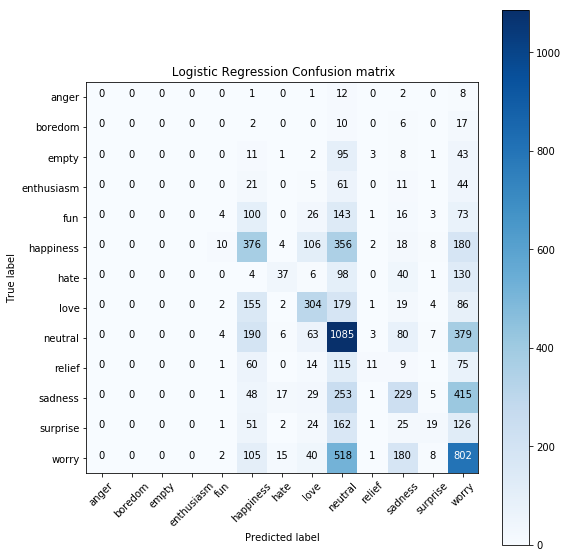

In [225]:
lr4 = LogisticRegression(multi_class='multinomial',solver='sag').fit(Xtrain_tf2, train_label2)
ypredlr4 = lr4.predict(Xtest_tf2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label2, ypredlr3), 
                      classes=["anger","boredom","empty","enthusiasm",
                               "fun","happiness","hate","love","neutral",
                               "relief","sadness","surprise","worry"],
                      title=' Logistic Regression Confusion matrix')

plt.show()

(m) Compare los resultados entre los clasificadores extendidos por defecto y los binarios que son extendidos mediante otras t´ecnicas, construya una tabla o gr´afico resumen. Los clasificadores que mejor se comportan en el caso binario ¿Siguen teniendo ese desempen˜o en mu´ltiples clases?